## [REINFORCEMENT LEARNING (DQN)](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html#reinforcement-learning-dqn-tutorial)

![](https://pytorch.org/tutorials/_images/cartpole.gif)

#### As the agent observes the current state of the environment and chooses an action, the environment transitions to a new state, and also returns a reward that indicates the consequences of the action. In this task, rewards are +1 for every incremental timestep and the environment terminates if the pole falls over too far or the cart moves more then 2.4 units away from center. This means better performing scenarios will run for longer duration, accumulating larger return.

#### The CartPole task is designed so that the inputs to the agent are 4 real values representing the environment state (position, velocity, etc.). We take these 4 inputs without any scaling and pass them through a small fully-connected network with 2 outputs, one for each action. The network is trained to predict the expected value for each action, given the input state. The action with the highest expected value is then chosen.

In [29]:
import gym

In [30]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [32]:
gym.envs.registry.keys()

dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v2', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'Reacher-v2', 'Reacher-v4', 'Pusher-v2', 'Pusher-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4'])

In [33]:
if gym.__version__[:4] == '0.26':
    env = gym.make('CartPole-v1')
else:
    raise ImportError(f"Requires gym v26, actual version: {gym.__version__}")

In [34]:
is_ipython = 'inline' in matplotlib.get_backend()

In [35]:
if is_ipython:
    from IPython import display

In [36]:
plt.ion() # interactive mode on

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [38]:
device

device(type='cpu')

### [Replay Memory](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html#replay-memory)

#### We’ll be using experience replay memory for training our DQN. It stores the transitions that the agent observes, allowing us to reuse this data later. By sampling from it randomly, the transitions that build up a batch are decorrelated. It has been shown that this greatly stabilizes and improves the DQN training procedure.

In [39]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

##### ReplayMemory - a cyclic buffer of bounded size that holds the transitions observed recently. It also implements a .sample() method for selecting a random batch of transitions for training.

In [40]:
class ReplayMemory(object):
    def __init__(self, capacity) -> None:
        self.memory = deque([], maxlen = capacity) # buffer store transitions

    def push(self, *args):
        """save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

##### Our environment is deterministic, so all equations presented here are also formulated deterministically for the sake of simplicity. In the RL literature, they would also contain expectations over stochastic transitions in the environment.

##### Our aim will be to train a policy $ \prod $ that tries to maximize the discounted, cumulative reward (DCR) $R_{t_0}= \sum_{t_0}^\infty \gamma^{t-t_0}r_t$ 

#####  A lower $\gamma$ makes rewards from the uncertain far future less important for our agent than the ones in the near future that it can be fairly confident about. It also encourages agents to collect reward closer in time than equivalent rewards temporally future away.

Reward function $Q^*: State \times Action \rightarrow \mathbb{R}$

$\pi^*(s) =\underset{x}{\arg\max} Q^*(s,a)$ take action a in a given state to maximize Q

#### But, since neural networks are universal function approximators, we can simply create one and train it to resemble $Q^*$ 

In [41]:
class DQN(nn.Module):
    def __init__(self, n_obs, n_arms):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_obs, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_arms)
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)


In [42]:
n_arms = env.action_space.n

In [43]:
state, _ = env.reset()

In [44]:
n_obs = len(state)

In [45]:
n_obs

4

In [46]:
BATCH_SIZE = 32
GAMMA = 0.88
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.05
LR = 1e-4

In [47]:
pi_net = DQN(n_obs, n_arms).to(device)
target_net = DQN(n_obs, n_arms).to(device)
target_net.load_state_dict(pi_net.state_dict())

<All keys matched successfully>

In [48]:
optimizer = optim.AdamW(pi_net.parameters(), lr=LR, amsgrad=True)

In [49]:
memory = ReplayMemory(10000)

In [50]:
steps_done = 0

#### select_action - will select an action accordingly to an epsilon greedy policy. Simply put, we’ll sometimes use our model for choosing the action, and sometimes we’ll just sample one uniformly. The probability of choosing a random action will start at EPS_START and will decay exponentially towards EPS_END. EPS_DECAY controls the rate of the decay.

In [51]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_DECAY) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return pi_net(state).max(1)[1].view(1,1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [52]:
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())

    if len(durations_t) >= 100:
        means =durations_t.unfold(0,100,1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)

    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())
    

In [53]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        #print(f'\t sorry')
        return
    transitions = memory.sample(BATCH_SIZE)
    #print('\t zip', *zip(*transitions))
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    #print(transitions)
    batch = Transition(*zip(*transitions))
    #print(f'batch {batch}')
    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)        
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    #print(f'non_final = {non_final_next_states}')
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    #print(f"action batch {action_batch}")
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net

    state_action_values = pi_net(state_batch).gather(1, action_batch)
    #print(f'state_action values={state_action_values}')
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.

    next_state_values = torch.zeros(BATCH_SIZE, device = device)

    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()

    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()

    loss.backward()

    torch.nn.utils.clip_grad_value_(pi_net.parameters(), 100)

    optimizer.step()



### [Training loop](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html#training-loop)

![](https://pytorch.org/tutorials/_images/reinforcement_learning_diagram.jpg)

In [54]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 1000

In [55]:
episode_durations = []

end of episode 999
9393


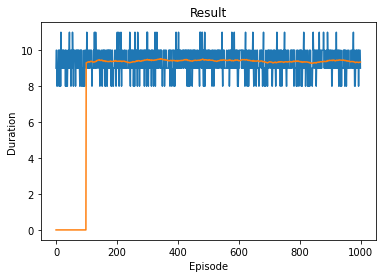

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [56]:
for i_eps in range(num_episodes):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        #print(f"state = {state}")
        action = select_action(state)
        #print(f'action={action}')
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        #print(f"observation = {observation}")
        #print(f'reward = {reward}')
        done = terminated or truncated
        
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        
        memory.push(state, action, next_state, reward)

        state = next_state

        optimize_model() # optimize the pi_net

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′

        target_net_state_dict = target_net.state_dict()
        pi_net_state_dict = pi_net.state_dict()

        for key in pi_net_state_dict:
            target_net_state_dict[key] = pi_net_state_dict[key] * TAU + target_net_state_dict[key] * (1-TAU)
        
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t+1)
            #plot_durations()
            break


print(f'end of episode {i_eps}')
print(len(memory))
plot_durations(show_result=True)
plt.ioff()
plt.show()



